# Demonstrate the FFT

Here we demonstrate how the FFT works on two cases:

1. A single-frequency sine wave
1. The [input CO$_2$ data from Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/ccgg/trends/)

In each case, we will look at the waveform in the "time" domain (which can also be the spatial domain depending on your dataset). We will take the FFT to transform to the "frequency" domain. However, *be extremely careful* with the FFT because the $x$-axis is *NOT* the frequency, but the spectral index. Given $N$ samples in the FFT, the true frequency $f$ is related to the spectral index $k$ by


$f = k/N$

In this case, $N = 1024$ and $k = 10$, so if the $x$ axis in the time domain is assumed to be in seconds, the frequency is $f=0.0098$ Hz. 



In [18]:
import matplotlib.pyplot as plt

from fft import fft, discrete_transform, fft_numba
import numpy as np
from numpy import pi
import math
import numba

In [19]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

## Simple Sine Wave

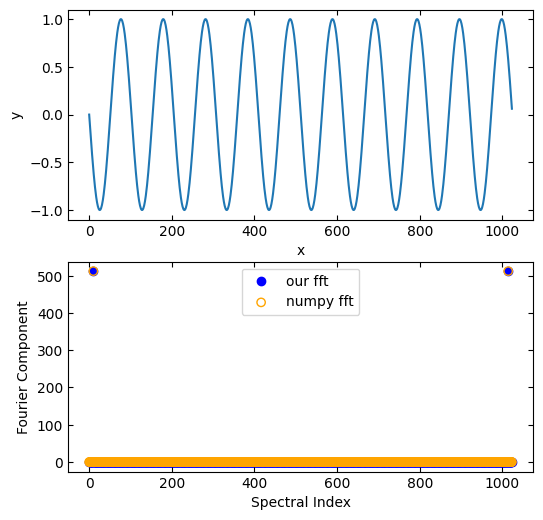

In [20]:
N = 1024 # number of samples
k = 10.0 # frequency = k / N
x = np.arange(N) 
y = np.sin(-2. * np.pi * (k / N) * x)  # Recall sin(wx) = sin(2 pi f x)
Y = fft(y)  # Our FFT implementation
Ynp = np.fft.fft(y) # Numpy's FFT implementation
Y_abs = abs(Y)
Ynp_abs = abs(Y)


fig, axs = plt.subplots(2, 1, figsize=(6, 6))
axs[0].plot( x, y )
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].scatter( x, Y_abs, label="our fft", facecolors="blue")
axs[1].scatter( x, Ynp_abs, label="numpy fft", facecolors="none", edgecolors="orange")
axs[1].set_ylabel('Fourier Component')
axs[1].set_xlabel('Spectral Index')
axs[1].legend(loc="upper center")
#axs[1].set_xlim([0,20])

plt.show()

In [21]:
# Just for fun, let's compare the performance
print("Our FFT:")
%timeit Y_fft = fft(y)  # Our FFT implementation
print("Numpy FFT:")
%timeit Y_np = np.fft.fft(y) # Numpy's FFT implementation
print("Our FFT with numba:")
%timeit Y_fft_numba = fft_numba(y) # Our FFT implemention with numba.njit
print("Discrete FT:")
%timeit Y_dft = discrete_transform(y)  # Our FFT implementation


Our FFT:
3.28 ms ± 36.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Numpy FFT:
5.39 μs ± 47.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Our FFT with numba:
295 μs ± 3.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Discrete FT:
1.19 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CO$_2$ Data

512


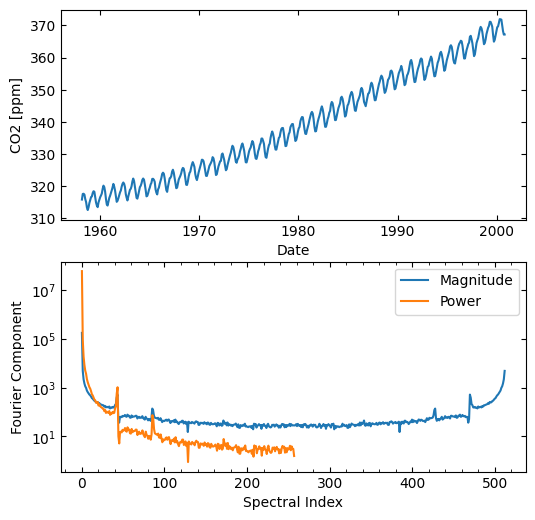

In [22]:
from read_co2 import read_co2

x,y = read_co2('co2_mm_mlo.txt')

y_valid = y >= 0.
y = y[y_valid]
x = x[y_valid]

y =y[0:512]
x =x[0:512]
Y = fft(y)
print(len(Y))

Y_abs = abs(Y)

power = np.zeros(257)
power[0] = abs(Y[0])**2
power[256] = abs(Y[256])**2
power[1:256] = abs(Y[1:256])**2 + abs(Y[511:257-1:-1])**2
power = power / 512

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'

fig, axs = plt.subplots(2, 1, figsize=(6, 6))
axs[0].plot(x, y)
axs[0].set_xlabel("Date")
axs[0].set_ylabel("CO2 [ppm]")

x_mag = np.linspace(0, len(x), len(x))
axs[1].plot(x_mag, Y_abs, label="Magnitude")
axs[1].set_xlabel('Spectral Index')
axs[1].set_ylabel('Fourier Component')
axs[1].set_yscale('log')

x_power = np.linspace(0, 257, 257)
axs[1].plot(x_power, power, label="Power")
axs[1].legend()
axs[1].xaxis.get_ticklocs(minor=True)
axs[1].yaxis.get_ticklocs(minor=True)
axs[1].minorticks_on()
#axs[1].tick_params(axis='x', which='minor', bottom=True, top=True)
#axs[1].tick_params(axis='y', which='minor', bottom=True, top=True)

plt.show()



The "spectral index" is a bit abstract, so let's convert it to a more human-friendly unit. The x-axis has units of "months," so we let's try converting the spectral index to a period (=1/frequency). 

The units reasoning goes like this: our Fourier transform components take the form $\sin(2\pi \frac{k}{N} x)$, where $k$ is the spectral index (ranging from 0 to $N-1$), $N$ is the number of measurements, and $x$ is the month. Remembering that the frequency of a sine wave, $f$, is used like $\sin(2\pi f x)$, we have $f=k/N$. Finally, the period is just the inverse of the frequency, $T=1/f=k/N$. 

/tmp/ipykernel_859/528237119.py:21: RuntimeWarning: divide by zero encountered in divide
  x_period_mag = len(x) / x_mag
/tmp/ipykernel_859/528237119.py:29: RuntimeWarning: divide by zero encountered in divide
  x_period_power = len(x) / x_power


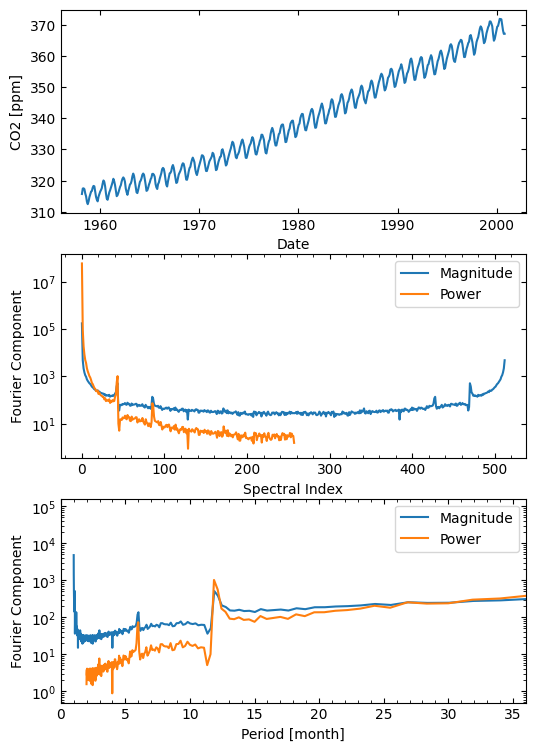

In [23]:
fig2, axs2 = plt.subplots(3, 1, figsize=(6, 9))
axs2[0].plot(x, y)
axs2[0].set_xlabel("Date")
axs2[0].set_ylabel("CO2 [ppm]")

x_mag = np.linspace(0, len(x), len(x))
axs2[1].plot(x_mag, Y_abs, label="Magnitude")
axs2[1].set_xlabel('Spectral Index')
axs2[1].set_ylabel('Fourier Component')
axs2[1].set_yscale('log')

x_power = np.linspace(0, 257, 257)
axs2[1].plot(x_power, power, label="Power")
axs2[1].legend()
axs2[1].xaxis.get_ticklocs(minor=True)
axs2[1].yaxis.get_ticklocs(minor=True)
axs2[1].minorticks_on()
#axs[1].tick_params(axis='x', which='minor', bottom=True, top=True)
#axs[1].tick_params(axis='y', which='minor', bottom=True, top=True)

x_period_mag = len(x) / x_mag
axs2[2].plot(x_period_mag, Y_abs, label="Magnitude")
axs2[2].set_xlabel('Period [month]')
axs2[2].set_ylabel('Fourier Component')
#axs[2].set_xscale('log')
axs2[2].set_xlim([0., 36.])
axs2[2].set_yscale('log')

x_period_power = len(x) / x_power
axs2[2].plot(x_period_power, power, label="Power")
axs2[2].legend()
axs2[2].xaxis.get_ticklocs(minor=True)
axs2[2].yaxis.get_ticklocs(minor=True)
axs2[2].minorticks_on()
#axs[1].tick_params(axis='x', which='minor', bottom=True, top=True)
#axs[1].tick_params(axis='y', which='minor', bottom=True, top=True)

plt.show()

